# Transformer
### The original transform for NLP and Time Series problem
https://arxiv.org/abs/1706.03762 <br>
https://www.tensorflow.org/tutorials/text/transformer <br>
Pytorch version will come soon <br>


In [1]:

import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import gc

In [2]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                              np.arange(d_model)[np.newaxis, :],
                              d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

(1, 50, 512)


In [3]:
# Calculate scaled dot product: q k v

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  
    # calculate attention weight:
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    # Attention (q.k.v)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights



def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
      
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)




    

In [4]:
# some temporary weights:


if True:
    np.set_printoptions(suppress=True)

    temp_k = tf.constant([[10,0,0],
                          [0,10,0],
                          [0,0,10],
                          [0,0,10]], dtype=tf.float32)  # (4, 3)

    temp_v = tf.constant([[   1,0],
                          [  10,0],
                          [ 100,5],
                          [1000,6]], dtype=tf.float32)  # (4, 2)
    temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
    print_out(temp_q, temp_k, temp_v)



Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [5]:
# Multi-head Attention:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        
        # Always use Super to inheriatte and avoid extra code.
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        # sanity check:
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        # Q K W:
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
    def split_heads(self, x, batch_size):
        # Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        # https://www.tensorflow.org/api_docs/python/tf/transpose : perm
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights
    
    
        
        
# check our Multi-head attention:

n_d_model=512
temp_mha = MultiHeadAttention(d_model=n_d_model, num_heads=8)
y = tf.random.uniform((1, 60, n_d_model))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape
    




(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [6]:
# Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.
def point_wise_feed_forward_network(d_model, dff):
    # Two FC layers:
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [7]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape
    
    

TensorShape([64, 50, 512])

# Encoder and Decoder:
### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [8]:
class EncoderLayer(tf.keras.layers.Layer):
    # Here we use a 0.1 dropout rate as default
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
        return out2
        
    

In [9]:
if True:
    sample_encoder_layer = EncoderLayer(512, 8, 2048)

    sample_encoder_layer_output = sample_encoder_layer(tf.random.uniform((64, 43, 512)), False, None)

    print(sample_encoder_layer_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 43, 512)


### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [10]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)
    

TensorShape([64, 50, 512])

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [11]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
    
        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x  # (batch_size, input_seq_len, d_model)
    
    
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)


(64, 62, 512)


### decoder 
 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [12]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights
    
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Let's create Transformer
Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [13]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
        
    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [14]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [15]:
sample_transformer.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (Encoder)          multiple                  10656768  
_________________________________________________________________
decoder_1 (Decoder)          multiple                  12504064  
_________________________________________________________________
dense_86 (Dense)             multiple                  4104000   
Total params: 27,264,832
Trainable params: 27,264,832
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Load data:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']


tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

print("Finish loading data")

Finish loading data


In [17]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


## MASK:
Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [18]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [19]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [20]:

def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
          lang1.numpy()) + [tokenizer_pt.vocab_size+1]

    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
          lang2.numpy()) + [tokenizer_en.vocab_size+1]

    return lang1, lang2


In [21]:
def tf_encode(pt, en):
    result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
    result_pt.set_shape([None])
    result_en.set_shape([None])

    return result_pt, result_en

In [22]:
MAX_LENGTH = 40
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [23]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64


train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [24]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

In [25]:

# Hyper parameteres:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1





## Optimizer
Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$



In [26]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    

In [27]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

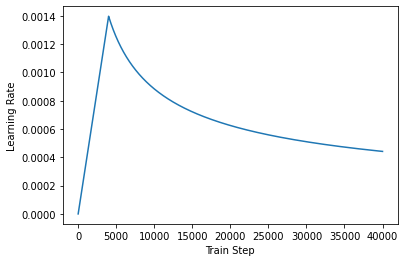

In [28]:
# Learning rate curve:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics
Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [29]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [30]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
  
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [31]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## Training and check points

In [32]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [33]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
  
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)
  
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [34]:
# check point
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
    

Latest checkpoint restored!!


In [35]:
EPOCHS = 20


train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)

def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)
    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tar_real, predictions)



In [36]:
for epoch in range(EPOCHS):
    start = time.time()
  
    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
    
        if batch % 200 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, batch, 
                                                                          train_loss.result(), train_accuracy.result()))
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
        
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))
        

Epoch 1 Batch 0 Loss 0.3307 Accuracy 0.4498
Epoch 1 Batch 200 Loss 0.2949 Accuracy 0.4317
Epoch 1 Batch 400 Loss 0.3043 Accuracy 0.4327
Epoch 1 Batch 600 Loss 0.3131 Accuracy 0.4307
Epoch 1 Loss 0.3188 Accuracy 0.4297
Time taken for 1 epoch: 91.41578984260559 secs

Epoch 2 Batch 0 Loss 0.2764 Accuracy 0.4145
Epoch 2 Batch 200 Loss 0.2908 Accuracy 0.4302
Epoch 2 Batch 400 Loss 0.3014 Accuracy 0.4296
Epoch 2 Batch 600 Loss 0.3120 Accuracy 0.4289
Epoch 2 Loss 0.3175 Accuracy 0.4285
Time taken for 1 epoch: 62.18143153190613 secs

Epoch 3 Batch 0 Loss 0.2547 Accuracy 0.3838
Epoch 3 Batch 200 Loss 0.2927 Accuracy 0.4298
Epoch 3 Batch 400 Loss 0.3013 Accuracy 0.4292
Epoch 3 Batch 600 Loss 0.3110 Accuracy 0.4287
Epoch 3 Loss 0.3159 Accuracy 0.4282
Time taken for 1 epoch: 62.220083475112915 secs

Epoch 4 Batch 0 Loss 0.2286 Accuracy 0.4403
Epoch 4 Batch 200 Loss 0.2883 Accuracy 0.4286
Epoch 4 Batch 400 Loss 0.3004 Accuracy 0.4296
Epoch 4 Batch 600 Loss 0.3094 Accuracy 0.4292
Epoch 4 Loss 0.3142

## Evaluate:
The following steps are used for evaluation:

* Encode the input sentence using the Portuguese tokenizer (`tokenizer_pt`). Moreover, add the start and end token so the input is equivalent to what the model is trained with. This is the encoder input.
* The decoder input is the `start token == tokenizer_en.vocab_size`.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity to keep the example relatively faster so the predictions maybe less right. To reproduce the results in the paper, use the entire dataset and base transformer model or transformer XL, by changing the hyperparameters above.

In [37]:
def evaluate(inp_sentence):
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]
  
    # inp sentence is portuguese, hence adding the start and end token
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)
  
    # as the target is english, the first word to the transformer should be the
    # english start token.
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
        
        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
        # return the result if the predicted_id is equal to the end token
        if predicted_id == tokenizer_en.vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights
    
        # concatentate the predicted_id to the output which is given to the decoder as its input.
        output = tf.concat([output, predicted_id], axis=-1)
    
    return tf.squeeze(output, axis=0), attention_weights
        
    

In [38]:
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))
  
    sentence = tokenizer_pt.encode(sentence)
    
    attention = tf.squeeze(attention[layer], axis=0)
    
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)
    
        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}
    
        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))
    
        ax.set_ylim(len(result)-1.5, -0.5)
        
        ax.set_xticklabels(
        ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                        if i < tokenizer_en.vocab_size], 
                       fontdict=fontdict)
    
        ax.set_xlabel('Head {}'.format(head+1))
  
    plt.tight_layout()
    plt.show()

def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
  
    predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
  
    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)
        
        


Input: este é um problema que temos que resolver.
Predicted translation: it 's a problem that we need to fix the first of the passes that we have to make our own humanity constelling .
Real translation: this is a problem we have to solve .
Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my neighbors had heard about this idea of me .
Real translation: and my neighboring homes heard about this idea .
Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so i 'm going to share very quickly share with you some pretty magic stories that had happened there .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .
Input: este é o primeiro livro que eu fiz.
Predicted translation: this is the first book i had .


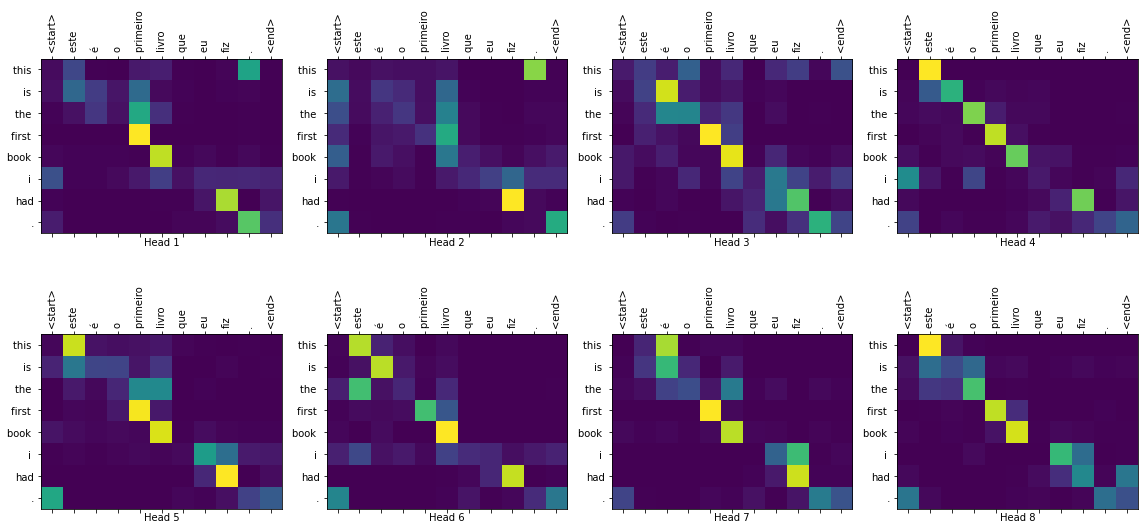

Real translation: this is the first book i've ever done.
Input: este é o primeiro livro que eu fiz.
Predicted translation: this is the first book i had .


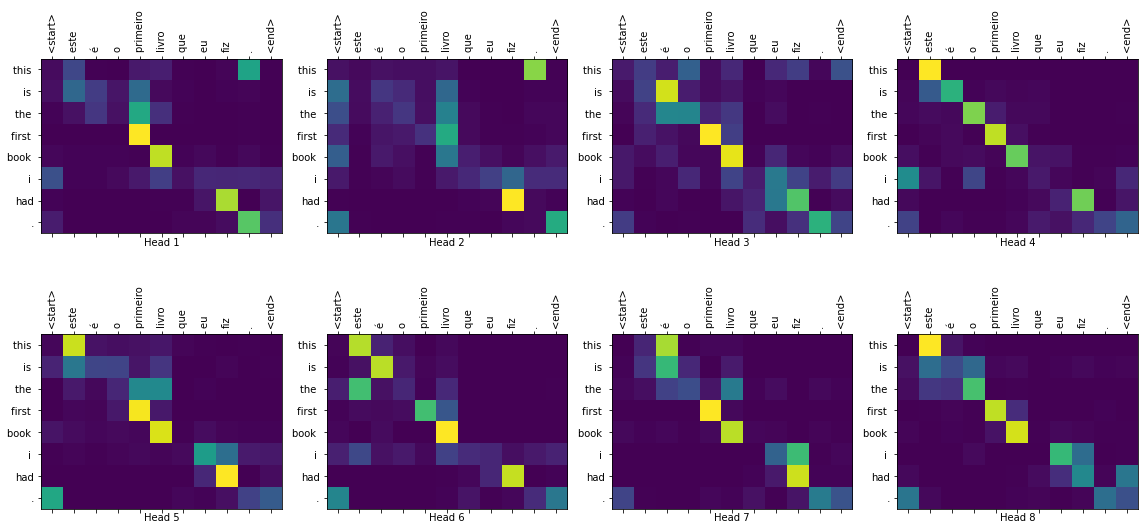

Real translation: this is the first book i've ever done.


In [39]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")


translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")



In [40]:
transformer.summary()

Model: "transformer_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_2 (Encoder)          multiple                  1844736   
_________________________________________________________________
decoder_2 (Decoder)          multiple                  2093696   
_________________________________________________________________
dense_151 (Dense)            multiple                  1043481   
Total params: 4,981,913
Trainable params: 4,981,913
Non-trainable params: 0
_________________________________________________________________


# Time series problem:
Encode time series into a smaller dimension
### Here is what we need to do:
### Change pe_target to output delta_t
### change pe_input to input delta_t
### position = np.arange(seq_len): length of a sliding window, which is pe_input and pe_target
### Here pe_input and 

### For GTX 1060 we can set batch=16 and use 4X batch size for Tesla P40

### for the output at final layer: output 1 rather than pe_target since it's not encoded data

In [19]:

# Let's say it's for Time-series (TS)
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        #self.final_layer = tf.keras.layers.Dense(target_vocab_size)
        ## output 1 for the last layer
        self.final_layer = tf.keras.layers.Dense(1)
        
        # calculate final value:
        self.mu = tf.keras.layers.Dense(1, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01))
        self.sigma = tf.keras.layers.Dense(1, activation='softplus',
                                           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01))
        
    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
        #print("check encoder size",enc_output.shape)

    
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        #print("check decoder size",dec_output.shape)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        #print("check output",self.mu(dec_output).shape)

        return final_output, attention_weights
        #return self.mu(dec_output), attention_weights

In [20]:
print("Done")

Done


In [15]:
import pandas as pd
import os
plot_path = "plots/"

# Real server data

root_path = "Data/Ant_202007/"


cif = pd.read_json(root_path+'cif.json', orient='index')
paycore = pd.read_json(root_path+'paycore.json', orient='index')
paydecision = pd.read_json(root_path+'paydecision.json', orient='index')
paydecision2 = pd.read_json(root_path+'paydecision2.json', orient='index')
paydecision3 = pd.read_json(root_path+'paydecision3.json', orient='index')

df = pd.DataFrame()
df["time_stamp"] = cif.index
df["cif"] = cif[0].values
df["paycore"] = paycore[0].values
df["paydecision"] = paydecision[0].values
df["paydecision2"] = paydecision2[0].values
df["paydecision3"] = paydecision3[0].values

# Optional
if False:
    df.to_csv(root_path+"fusion.csv")

    
# convert time stamp
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
names_array = np.array(df.keys()[1:],dtype="str")
os.listdir(root_path)


if True:
    
    # calculate previous hour high low:
    # convert to seconds
    temp = df['time_stamp'] - min(df['time_stamp'])
    temp = temp.dt.total_seconds().astype(int)
    df["hours"] = temp//3600

    h_max = max(df["hours"])+1

    for n in range(len(names_array)):
        df[names_array[n]+"_open"] = df[names_array[n]]
        df[names_array[n]+"_close"] = df[names_array[n]]
        df[names_array[n]+"_max"] = df[names_array[n]]
        df[names_array[n]+"_min"] = df[names_array[n]]

    for j in range(1,h_max):
        mask_j = df["hours"]==j-1
        max_val = df[mask_j][names_array].max(axis=0).values
        min_val = df[mask_j][names_array].max(axis=0).values
        open_val = df[mask_j][names_array].values[0,:]
        close_val = df[mask_j][names_array].values[-1,:]
        mask_i = df["hours"]==j
        r = df[mask_i][names_array].shape[0]
        df.loc[mask_i,[r+"_open" for r in names_array]] = np.tile(open_val,(r,1))
        df.loc[mask_i,[r+"_close" for r in names_array]] = np.tile(close_val,(r,1))

        df.loc[mask_i,[r+"_max" for r in names_array]] = np.tile(max_val,(r,1))
        df.loc[mask_i,[r+"_min" for r in names_array]] = np.tile(min_val,(r,1))
    
    



In [16]:

temp = df["cif"]
# Normalize to 0-1000

temp = (temp-min(temp))/(max(temp)-min(temp))

lower, upper = 0, 999
temp = [lower + (upper - lower) * x for x in temp]
temp = np.array(temp,dtype=int)
delta_t = 720

X = np.zeros((temp.shape[0]-delta_t,delta_t,1),dtype=int)
y = temp[delta_t:]

for i in range(len(y)):
    if i%10000==0:
        print("Prepare data %.2f percent"%(100*i/len(y)))
    X[i,:,:] = np.atleast_2d(temp[i:i+delta_t]).T
train_dataset_TS = tf.data.Dataset.from_tensor_slices((X,y))



Prepare data 0.00 percent
Prepare data 24.37 percent
Prepare data 48.73 percent
Prepare data 73.10 percent
Prepare data 97.46 percent


In [59]:

batch = 8

sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=1000, target_vocab_size=1000, 
    pe_input=1440, pe_target=240)


transformer = sample_transformer

In [60]:
#temp_input = tf.cast(X[:8,:,:],dtype=tf.int64)
#temp_target = temp_input = tf.cast(y[:8],dtype=tf.int64)




temp_input.shape

TensorShape([8])

In [66]:
# sanity check:

temp_input = tf.random.uniform((batch, 720), dtype=tf.int64, minval=0, maxval=1000)
temp_target = tf.random.uniform((batch, 1), dtype=tf.int64, minval=0, maxval=1000)



fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

print("final output size",fn_out.shape)  # (batch_size, tar_seq_len, target_vocab_size)


final output size (8, 1, 1)


In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

      
    return enc_padding_mask, combined_mask, dec_padding_mask



In [69]:

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
  
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)





In [70]:

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
  
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
        loss = loss_function(tar_real, predictions)
        
    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tar_real, predictions)
    #return loss
    




In [ ]:
EPOCHS = 10
for epoch in range(EPOCHS):
    start = time.time()
  
    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
    
        if batch % 200 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, batch, 
                                                                          train_loss.result(), train_accuracy.result()))
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
        
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))
        

In [53]:
batch=32
for (batch, (inp, tar)) in enumerate(train_dataset_TS):
    print(inp.shape,tar.shape)

(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720

(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720

(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720

(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720

(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720

(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720

(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720

(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720

(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720

(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720

(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720

(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720

(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720

(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720

(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720

(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720

(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720

(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720

(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()
(720, 1) ()


KeyboardInterrupt: 

In [ ]:
train_step(temp_input,temp_target)